In [ ]:
from pyspark.sql import SparkSession

# Cloud storage constants
S3_BUCKET = "your-bucket-name"
S3_PATH = f"s3a://{S3_BUCKET}/data/parquet/"

def create_spark_session(app_name="IMDb Analytics", cloud_provider="s3"):
    """
    Tạo và cấu hình SparkSession với các thiết lập cho cloud storage.
    
    Parameters:
        app_name (str): Tên của ứng dụng Spark
        cloud_provider (str): Loại cloud storage (s3, gcs, azure)
        
    Returns:
        SparkSession: SparkSession đã được cấu hình
    """
    builder = SparkSession.builder.appName(app_name)
    
    # Cấu hình cơ bản
    builder = builder \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.cores", "2") \
        .config("spark.driver.cores", "2") \
        .config("spark.sql.files.maxPartitionBytes", "128MB") \
        .config("spark.sql.shuffle.partitions", "10")

    # Cấu hình cho Amazon S3
    if cloud_provider == "s3":
        builder = builder \
            .config("spark.hadoop.fs.s3a.access.key", "YOUR_ACCESS_KEY") \
            .config("spark.hadoop.fs.s3a.secret.key", "YOUR_SECRET_KEY") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
                   "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")
    
    # Cấu hình cho Google Cloud Storage
    elif cloud_provider == "gcs":
        builder = builder \
            .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
            .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", 
                   "path/to/your/service-account-key.json")
    
    # Cấu hình cho Azure Blob Storage
    elif cloud_provider == "azure":
        builder = builder \
            .config("spark.hadoop.fs.azure.account.key.YOUR_STORAGE_ACCOUNT.blob.core.windows.net",
                   "YOUR_STORAGE_ACCESS_KEY")

    return builder.getOrCreate()

def test_cloud_connection(spark, cloud_path):
    """
    Kiểm tra kết nối tới cloud storage
    
    Parameters:
        spark (SparkSession): SparkSession đã được khởi tạo
        cloud_path (str): Đường dẫn đến thư mục trên cloud storage
        
    Returns:
        bool: True nếu kết nối thành công, False nếu thất bại
    """
    try:
        test_df = spark.read.parquet(f"{cloud_path}/title_basics_parquet")
        test_df.printSchema()
        return True
    except Exception as e:
        print(f"Lỗi kết nối cloud storage: {str(e)}")
        return False



In [ ]:
class CloudIMDbDataLoader:
    def __init__(self, spark, cloud_path):
        """
        Initialize with cloud storage path
        
        Parameters:
            spark (SparkSession): SparkSession instance
            cloud_path (str): Base path trên cloud storage (e.g., s3a://bucket/path)
        """
        self.spark = spark
        self.base_path = cloud_path
    
    def load_titles(self):
        return self.spark.read.parquet(f"{self.base_path}/title_basics_parquet")
    
    def load_ratings(self):
        return self.spark.read.parquet(f"{self.base_path}/title_ratings_parquet")
    
    def load_names(self):
        return self.spark.read.parquet(f"{self.base_path}/name_basics_parquet")
    
    def load_akas(self):
        return self.spark.read.parquet(f"{self.base_path}/title_akas_parquet")
        
    def load_episodes(self):
        return self.spark.read.parquet(f"{self.base_path}/title_episode_parquet")
    
    def load_principals(self):
        return self.spark.read.parquet(f"{self.base_path}/title_principals_parquet")
    
    def load_crews(self):
        return self.spark.read.parquet(f"{self.base_path}/title_crew_parquet")

In [31]:
from pyspark.sql.functions import col, explode, split, when, count, collect_set, desc
from pyspark.sql.window import Window

class MovieAnalyzer:
    def __init__(self, movies_df, crew_df, principals_df):
        """
        Initialize with three dataframes:
        - movies_df: Contains movie information
        - crew_df: Contains directors and writers information
        - principals_df: Contains detailed crew information (from the first table shown)
        """
        self.movies_df = movies_df
        self.crew_df = crew_df
        self.principals_df = principals_df
        
    def get_genre_distribution(self):
        """Analyze movie genre distribution"""
        return self.movies_df.select(
            explode(split("genres", ",")).alias("genre")
        ).groupBy("genre").count().orderBy(desc("count"))
    
    def get_director_productivity(self):
        """Analyze most productive directors"""
        # Using the crew_df which has directors column
        return self.crew_df.select(
            explode(split("directors", ",")).alias("director_id")
        ).filter(
            col("director_id").isNotNull()
        ).groupBy("director_id").count().orderBy(desc("count")).limit(10)
    
    def get_job_distribution(self):
        """Analyze distribution of roles in film crew"""
        # Using principals_df instead of crew_df
        return self.principals_df.groupBy("category", "job").count().orderBy(desc("count"))
    
    def get_multi_role_people(self):
        """Find people with multiple roles"""
        return self.principals_df.groupBy("nconst").agg(
            count("category").alias("num_roles"),
            collect_set("category").alias("roles")
        ).orderBy(desc("num_roles")).limit(10)
    
    def get_collaboration_network(self):
        """Analyze collaboration network between directors and producers"""
        # Using principals_df for this analysis
        directors = self.principals_df.filter(
            col("category") == "director"
        ).select("tconst", "nconst").withColumnRenamed("nconst", "director_id")
        
        producers = self.principals_df.filter(
            col("category") == "producer"
        ).select("tconst", "nconst").withColumnRenamed("nconst", "producer_id")
        
        return directors.join(producers, "tconst").groupBy(
            "director_id", "producer_id"
        ).count().orderBy(desc("count"))

In [ ]:
import setuptools.dist
import matplotlib.pyplot as plt
import seaborn as sns

class MovieVisualizer:
    @staticmethod
    def plot_genre_distribution(genre_df):
        """Plot genre distribution"""
        plt.figure(figsize=(12, 6))
        data = genre_df.toPandas()
        sns.barplot(data=data, x='genre', y='count')
        plt.title("Movie Genre Distribution")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Genre")
        plt.ylabel("Count")
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_job_distribution(job_df):
        """Plot job distribution in film crew"""
        plt.figure(figsize=(15, 8))
        data = job_df.toPandas()
        # Set explicit legend position instead of 'best'
        ax = sns.barplot(data=data, x='category', y='count', hue='job')
        plt.title("Job Distribution in Film Crew")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Category")
        plt.ylabel("Count")
        # Move legend outside the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        # Adjust layout to prevent label cutoff and accommodate legend
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_director_productivity(director_df):
        """Plot top directors"""
        plt.figure(figsize=(12, 6))
        data = director_df.toPandas()
        sns.barplot(data=data, x='director_id', y='count')
        plt.title("Top Directors by Number of Films")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Director ID")
        plt.ylabel("Number of Films")
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_collaboration_network(collab_df):
        """Plot collaboration network"""
        plt.figure(figsize=(12, 8))
        data = collab_df.toPandas()
        plt.scatter(data['director_id'], data['producer_id'], 
                   s=data['count']*10, alpha=0.6)
        plt.title("Director-Producer Collaboration Network")
        plt.xlabel("Director ID")
        plt.ylabel("Producer ID")
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_multi_role_distribution(role_df):
        """Plot multi-role distribution"""
        plt.figure(figsize=(12, 6))
        data = role_df.toPandas()
        ax = sns.barplot(data=data, x='nconst', y='num_roles')
        # Add role labels on top of each bar
        for i, roles in enumerate(data['roles']):
            plt.text(i, data['num_roles'][i], str(roles), 
                    rotation=90, ha='center', va='bottom')
        plt.title("Top Multi-Role Contributors")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Person ID")
        plt.ylabel("Number of Roles")
        plt.tight_layout()
        return plt.gcf()

In [8]:
spark = create_spark_session()
# Đọc file Parquet
loader = IMDbDataLoader(spark, "hdfs:///hadoop/data/parquet/")


In [9]:
titles_df = loader.load_titles()
rating_df = loader.load_ratings()
names_df = loader.load_names()
akas_df = loader.load_akas()
episode_df = loader.load_episodes()
principal_df = loader.load_principals()
crew_df = loader.load_crews()


In [10]:
print("===================Titles Schema====================")
titles_df.printSchema(5)
titles_df.show(5)
print("===================Rating Schema====================")
rating_df.printSchema(5)
rating_df.show(5)
print("===================Names Schema====================")
names_df.printSchema(5)
names_df.show(5)
print("===================Akas Schema====================")
akas_df.printSchema(5)
akas_df.show(5)
print("===================Episode Schema====================")
episode_df.printSchema(5)
episode_df.show(5)
print("===================Principal Schema====================")
principal_df.printSchema(5)
principal_df.show(5)
print("===================Crew Schema====================")
crew_df.printSchema(5)
crew_df.show(5)


===================Titles Schema====================
root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+---------------+
|    tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|         genres|
+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+---------------+
| tt7567992|tvEpisode|       Episode #1.39|       Episode #1.39|      0|     2012|   NULL|          NULL|          Drama|
| tt3714186|tvEpisode|       Super Airship|       Super Airship|      0|     2014|   NULL|            44|    Documentary|
|tt29790156|tvEpisode|Vanessa Bell Call...|Vanessa Bell Call...|      0|     2023|   NULL|          NULL|      Talk-Show|
|tt10126220|tvEpisode|Joker Trailer and...|Joker Trailer and...|      0|     2019|   NULL|          NULL|           News|
| tt3120808|tvEpisode|               Spoon|               Spoon|      0|     2011|   NULL|          NULL|Music,Talk-Show|
+----------+---------+--

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|actor,miscellaneo...|tt0050419,tt00723...|
|nm0000002|  Lauren Bacall|     1924|     2014|actress,soundtrac...|tt0037382,tt00752...|
|nm0000003|Brigitte Bardot|     1934|     NULL|actress,music_dep...|tt0057345,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,musi...|tt0072562,tt00779...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00694...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 5 rows

===================Akas Schema====================
root
 |-- titleId: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- title: string (nullable =

+----------+--------+--------------------+------+--------+--------+----------+---------------+
|   titleId|ordering|               title|region|language|   types|attributes|isOriginalTitle|
+----------+--------+--------------------+------+--------+--------+----------+---------------+
| tt7310226|       3|       एपिसोड #1.122|    IN|      hi|    NULL|      NULL|              0|
|tt21971816|       4|       Épisode #1.15|    FR|      fr|    NULL|      NULL|              0|
|tt14837298|       1|    578 days waiting|  NULL|    NULL|original|      NULL|              1|
|tt31835460|       6|        Folge #1.225|    DE|      de|    NULL|      NULL|              0|
|tt33284890|       1|Les grands voyageurs|  NULL|    NULL|original|      NULL|              1|
+----------+--------+--------------------+------+--------+--------+----------+---------------+
only showing top 5 rows

===================Episode Schema====================
root
 |-- tconst: string (nullable = true)
 |-- parentTconst: stri

+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                NULL|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                NULL|      NULL|
|tt0000001|       3|nm0005690|       producer|            producer|      NULL|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|      NULL|
|tt0000002|       1|nm0721526|       director|                NULL|      NULL|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows

===================Crew Schema====================
root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)

+----------+---------+-------------------+
|    tconst|directors|            writers|
+--

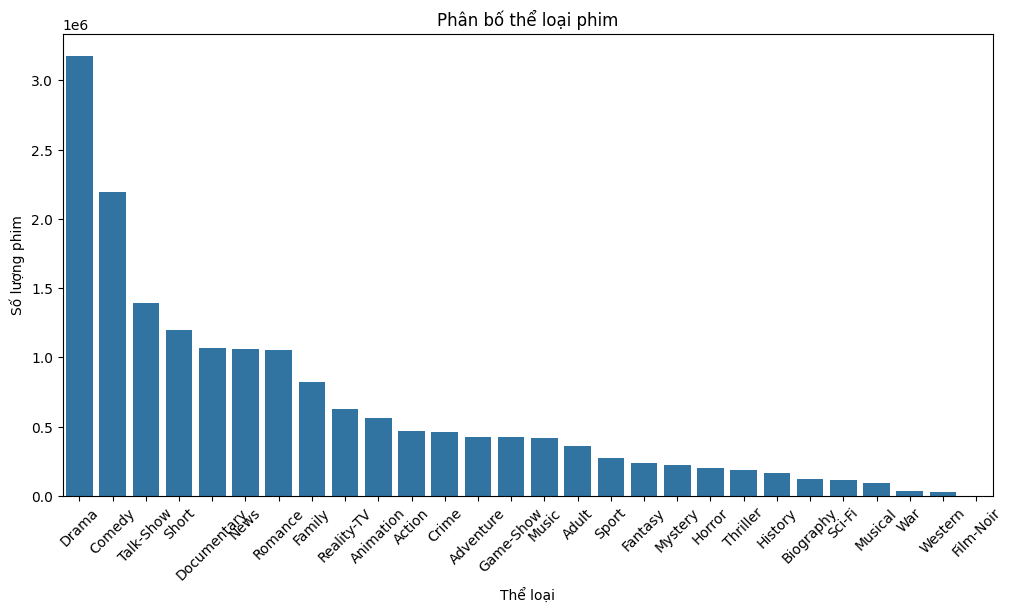

KeyboardInterrupt: 

In [ ]:
analyzer = MovieAnalyzer(titles_df, crew_df, principal_df)
visualizer = MovieVisualizer()

# Phân tích và vẽ biểu đồ thể loại
genre_dist = analyzer.get_genre_distribution()
genre_plot = visualizer.plot_genre_distribution(genre_dist)
plt.show()

# Phân tích và vẽ biểu đồ phân bố vai trò
job_dist = analyzer.get_job_distribution()
job_plot = visualizer.plot_job_distribution(job_dist)
plt.show()